In [1]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda
from numba import vectorize, int64, float32


## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
#vectorized version of log
@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_log(x):
    c =  np.log(x) #ln
    return c

A=np.array([2, 5, 10, 3, 8], dtype=np.float32)
print("Vectorized version of log: ",vec_log(A))


#vectorized version of exp 
@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_exp(x):
    c =  np.exp(x) 
    return c

print("Vectorized version of exp: ",vec_exp(A))


Vectorized version of log:  [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Vectorized version of exp:  [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
#code ex2
from scipy import stats
from scipy.stats import truncnorm
from numba import jit, int32, float64


#WHY WORKS ONLY WITH NOPYTHON??????????????????????????????????????????

@jit(nopython=True) #compiler generate code with the highest performance, but all native types of all values in the function can be inferred.
def pdf(x, mu, sigma):
    return (1/np.sqrt(2*math.pi)*sigma)*np.exp((-1/2)*((x-mu)/(sigma))**2)

mu, sigma = 1,1
N=100000
x_values = np.linspace(-3,3, N).astype(np.float32)
pdf(x_values,1,1)




array([0.00013383, 0.00013386, 0.00013389, ..., 0.05400392, 0.05399745,
       0.05399097])

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

[-1  0  1 ...  5 -6 -4]
[-1  0  1 ...  5 -6 -4]


Text(0.5, 1.0, 'Data after zero_suppress function')

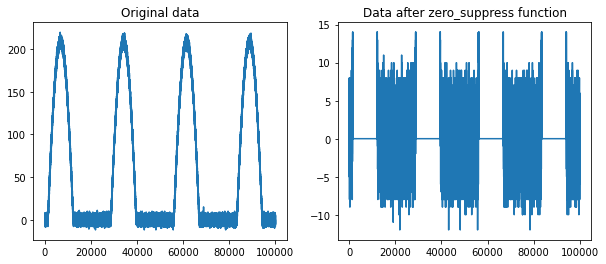

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)
print(data)

#Create a "zero suppression" function. 
#force all samples values below a certain absolute magnitude to be zero, to eliminate low amplitude noise. 

magnitude_max=15 
@jit 
def zero_suppression(magnitude_max,data):
        new_data=np.where(data < magnitude_max, data, 0) 
        return new_data
    
new_data=zero_suppression(magnitude_max,data)
print(new_data)  #NON MI TORNA MOOLTO....-2 dovrebbe venire 0 in new data???????????????


#Plot the data before and after the application of the zero_suppress function.
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(data)
ax1.set_title("Original data",fontsize=12)

ax2.plot(new_data)
ax2.set_title("Data after zero_suppress function",fontsize=12)

    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@cuda.jit(device=True)
def k(x,y,a,c):
    return np.tanh(a*x.T*y+c)

print(k(X,Y,1,1))

#a,c?????????????????????????????????????????????

#usare cuda grid....


[[0.91419549 0.85838129 0.90764831]
 [0.84333281 0.8109148  0.86671991]
 [0.80837293 0.86874471 0.82336763]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
#code ex5

# CUDA kernel
@cuda.jit
def kernel3D(io_array):
    row, col = cuda.grid(2)
    io_array[row][col] = np.cos(io_array[row][col]) # do the computation

# Host code   
data = np.random.random((256,256,256))

# Configure the blocks CHE VALORI METTOOOOOOOOOOOO?????????????????????????????
threadsperblock = (16,16,1)#ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1 
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#print("lla \n",data)
kernel3D[blockspergrid, threadsperblock](data)
print(data)


[[[0.75335112 0.87600734 0.93374372 ... 0.68991285 0.99816534 0.93612862]
  [0.54840608 0.63836469 0.63792591 ... 0.71190033 0.999372   0.67070854]
  [0.90540359 0.58097718 0.65955782 ... 0.87973205 0.91646537 0.78613435]
  ...
  [0.65236999 0.91149064 0.91349195 ... 0.98247872 0.58558211 0.68880075]
  [0.79612737 0.97809619 0.92396117 ... 0.91836971 0.6808768  0.99563229]
  [0.85117152 0.90756206 0.64027342 ... 0.96756634 0.9929898  0.79676217]]

 [[0.66804301 0.8439958  0.87537451 ... 0.95750516 0.94916303 0.98857255]
  [0.756522   0.91577365 0.77479931 ... 0.68933807 0.91074596 0.99971656]
  [0.73999129 0.98675306 0.67793105 ... 0.99814255 0.59662886 0.60289295]
  ...
  [0.6982952  0.69689215 0.92362269 ... 0.69285843 0.82719204 0.87198919]
  [0.94366162 0.80627707 0.54429098 ... 0.64193738 0.7123665  0.92120919]
  [0.99902846 0.99999014 0.96654403 ... 0.84433413 0.99942901 0.81114548]]

 [[0.91151726 0.76020699 0.61463186 ... 0.74186309 0.87448184 0.96777982]
  [0.89726652 0.981959

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [10]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint((24,12))
B = np.random.randint((12,22))   
A_device = cuda.to_device(A)
B_device = cuda.to_device(B)

# Allocate memory for the result
C_device = cuda.device_array((24, 22))

cuda.synchronize()

#me #NUMERI??????
# Configure the blocks
threadsperblock = (12,11)#ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1 
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#kernel 
matmul[blockspergrid, threadsperblock](A_device,B_device,C_device)
cuda.synchronize()
C = C_device.copy_to_host()

print(C)
#WHAT I AM DOING?

IndexError: tid=[6, 9, 0] ctaid=[0, 0, 0]: tuple index out of range